In [1]:
!pip install --upgrade tensorflow-graphics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.6/694.6 kB 29.9 MB/s eta 0:00:00


In [2]:
!pip install trimesh

In [ ]:
import numpy as np
import h5py
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, LeakyReLU, MaxPooling3D, UpSampling3D, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau

keras.backend.clear_session()

# Load data
with h5py.File('/content/drive/MyDrive/object40.hdf5', 'r') as f:
    train_data = f['train_mat'][...]
    val_data = f['val_mat'][...]
    test_data = f['test_mat'][...]

train_data = train_data.reshape([-1, 32, 32, 32, 1])
val_data = val_data.reshape([-1, 32, 32, 32, 1])
test_data = test_data.reshape([-1, 32, 32, 32, 1])


# Model definition
input_img = Input(shape=(32, 32, 32, 1))

# Encoder
x = Conv3D(64, (3, 3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x1 = MaxPooling3D((2, 2, 2), padding='same')(x)

x = Conv3D(128, (3, 3, 3), padding='same')(x1)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x2 = MaxPooling3D((2, 2, 2), padding='same')(x)

x = Conv3D(256, (3, 3, 3), padding='same')(x2)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
encoded = MaxPooling3D((2, 2, 2), padding='same')(x)

# Decoder
x = Conv3D(256, (3, 3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = UpSampling3D((2, 2, 2))(x)

x = concatenate([x, x2])
x = Dropout(0.2)(x)
x = Conv3D(128, (3, 3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = UpSampling3D((2, 2, 2))(x)

x = concatenate([x, x1])
x = Dropout(0.2)(x)
x = Conv3D(64, (3, 3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = UpSampling3D((2, 2, 2))(x)

decoded = Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

# Callbacks
# tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)

# Model training
autoencoder.fit(train_data, train_data,
                epochs=50,
                batch_size=128,
                validation_data=(val_data, val_data),
                callbacks=[reduce_lr])

autoencoder.save('autoencoder40.h5')
print("Training finished...")


Epoch 1/50
77/77 [==============================] - 117s 1s/step - loss: 0.0768 - val_loss: 0.1980 - lr: 0.0010
Epoch 2/50
77/77 [==============================] - 51s 667ms/step - loss: 0.0191 - val_loss: 0.1824 - lr: 0.0010
Epoch 3/50
77/77 [==============================] - 51s 669ms/step - loss: 0.0134 - val_loss: 0.2009 - lr: 0.0010
Epoch 4/50
77/77 [==============================] - 51s 667ms/step - loss: 0.0105 - val_loss: 0.1638 - lr: 0.0010
Epoch 5/50
77/77 [==============================] - 51s 669ms/step - loss: 0.0088 - val_loss: 0.1002 - lr: 0.0010
Epoch 6/50
77/77 [==============================] - 51s 668ms/step - loss: 0.0076 - val_loss: 0.0542 - lr: 0.0010
Epoch 7/50
77/77 [==============================] - 51s 668ms/step - loss: 0.0068 - val_loss: 0.0197 - lr: 0.0010
Epoch 8/50
77/77 [==============================] - 51s 669ms/step - loss: 0.0061 - val_loss: 0.0098 - lr: 0.0010
Epoch 9/50
77/77 [==============================] - 51s 667ms/step - loss: 0.0056 - val_lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
from keras.models import load_model
import h5py
import numpy as np
# import mrcfile as mrc
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from keras import backend as K
K.clear_session()

with h5py.File('/content/drive/MyDrive/object40.hdf5', 'r') as f:
    train_data = f['train_mat'][...]
    val_data = f['val_mat'][...]
    test_data = f['test_mat'][...]

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

train_num = train_data.shape[0]
val_num = val_data.shape[0]
test_num = test_data.shape[0]
box_size = train_data.shape[1]

train_data = train_data.reshape([-1, box_size, box_size, box_size, 1])
val_data = val_data.reshape([-1, box_size, box_size, box_size, 1])
test_data = test_data.reshape([-1, box_size, box_size, box_size, 1])

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

autoencoder = load_model('/content/drive/MyDrive/autoencoder40.h5')
decoded_imgs = autoencoder.predict(test_data, batch_size=100)

# Apply thresholding to clean up the output
def apply_threshold(predictions, threshold=0.75):
    predictions[predictions >= threshold] = 1
    predictions[predictions < threshold] = 0
    return predictions

# Using the thresholding function on the predictions
decoded_imgs = autoencoder.predict(test_data)
decoded_imgs = apply_threshold(decoded_imgs)

decoded_imgs = decoded_imgs.reshape(test_num, box_size, box_size, box_size)
print("decoded imgs shape is:")
print(decoded_imgs.shape)

# write back to hdf5 file
hdf5_file = h5py.File("reconstruction.hdf5", "w")
hdf5_file.create_dataset("recon_mat", decoded_imgs.shape, np.int8)
for i in range(len(decoded_imgs)):
    hdf5_file["recon_mat"][i] = decoded_imgs[i]

hdf5_file.close()
print('Reconstruction HDF5 file successfully created.')


(9843, 32, 32, 32)
(1234, 32, 32, 32)
(1234, 32, 32, 32)
(9843, 32, 32, 32, 1)
(1234, 32, 32, 32, 1)
(1234, 32, 32, 32, 1)
39/39 [==============================] - 6s 126ms/step
decoded imgs shape is:
(1234, 32, 32, 32)
Reconstruction HDF5 file successfully created.


In [4]:
# Function to plot a single voxel grid
def plot_voxel(voxels, ax, title, important=None):
    ax.set_title(title)
    ax.voxels(voxels, facecolors='blue', edgecolor='k')
    if important is not None:
        ax.voxels(voxels * important, facecolors='red', edgecolor='k')  # Important voxels

# Load the model and data
def load_data():
    with h5py.File('/content/drive/MyDrive/object40.hdf5', 'r') as f:
        # print('keys', f.keys())
        original_data = f['test_mat'][...]
        labels = f['test_label'][...]

    with h5py.File('reconstruction.hdf5', 'r') as f:
        reconstructed_data = f['recon_mat'][...]

    return original_data, reconstructed_data, labels

# label_dict = {
#     0: 'bathtub', 1: 'bed', 2: 'chair', 3: 'desk', 4: 'dresser',
#     5: 'monitor', 6: 'night_stand', 7: 'sofa', 8: 'table', 9: 'toilet',
# }

label_dict = {0: "lamp", 1: "wardrobe", 2: "bench", 3: "piano", 4: "car", 5: "bed", 6: "monitor", 7: "cup", 8: "radio", 9: "mantel", 10: "desk", 11: "plant", 12: "xbox", 13: "curtain", 14: "person", 15: "stool", 16: "range_hood", 17: "guitar", 18: "chair", 19: "sink", 20: "bookshelf", 21: "dresser", 22: "cone", 23: "vase", 24: "glass_box", 25: "tent", 26: "toilet", 27: "sofa", 28: "bowl", 29: "table", 30: "flower_pot", 31: "airplane", 32: "night_stand", 33: "bathtub", 34: "tv_stand", 35: "laptop", 36: "stairs", 37: "bottle", 38: "keyboard", 39: "door"}

def visualize_objects(original_data, reconstructed_data, labels, important_voxels=None, num_samples=5):
    # Randomly select a few samples to display
    indices = np.random.choice(original_data.shape[0], num_samples, replace=False)

    fig = plt.figure(figsize=(15, num_samples * 6))

    for i, idx in enumerate(indices):
        original = original_data[idx, :, :, :].astype(bool)
        reconstructed = reconstructed_data[idx, :, :, :].astype(bool)

        # Plotting original data
        ax = fig.add_subplot(num_samples, 2, 2 * i + 1, projection='3d')

        if important_voxels is not None:
          important = important_voxels[idx, :, :, :].astype(bool)


        plot_voxel(original, ax, f'Original {label_dict[int(labels[idx])]}', important=important if important_voxels is not None else None)

        # Plotting reconstructed data
        ax = fig.add_subplot(num_samples, 2, 2 * i + 2, projection='3d')
        plot_voxel(reconstructed, ax, f'Reconstructed {label_dict[int(labels[idx])]}')

    plt.tight_layout()
    plt.savefig('comparison_1.png')  # Save the figure
    plt.show()

original_data, reconstructed_data, labels = load_data()
# original_data.shape, reconstructed_data.shape, labels.shape

# visualize_objects(original_data, reconstructed_data, labels)

hdf5_file.close()

In [48]:
from keras.models import load_model
import h5py
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from keras import backend as K
import keras

K.clear_session()

def calculate_gradients(input_data, batch_size=10):
    gradients = []
    for i in range(0, len(input_data), batch_size):
        input_tensor = tf.Variable(input_data[i:i+batch_size], dtype=tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(input_tensor)
            reconstructed = autoencoder(input_tensor)
            loss = tf.reduce_mean(tf.square(reconstructed - input_tensor))
        grad = tape.gradient(loss, input_tensor)
        for item in grad.numpy():
          gradients.append(item)
    return np.array(gradients)

# Thresholding to identify important voxels
def identify_important_voxels(gradients, threshold=0.01):
    importance = np.linalg.norm(gradients, axis=-1)
    # return importance > threshold
    # Calculate the 90th percentile threshold along each axis
    percentile_threshold = np.percentile(importance, 90, axis=None)

    # Identify elements above the threshold using absolute value
    mask = importance > percentile_threshold
    return mask

def compute_local_means(gradients, window_size=3):
    # Assuming gradients is a 5D tensor (batch, x, y, z, channel)
    dims = gradients.shape
    local_means = np.zeros(dims)

    # Padding array to handle borders
    padded_gradients = np.pad(gradients, [(0, 0), (window_size//2, window_size//2),
                                          (window_size//2, window_size//2), (window_size//2, window_size//2), (0, 0)], mode='constant', constant_values=0)

    # Compute local means
    for i in range(dims[1]):
        for j in range(dims[2]):
            for k in range(dims[3]):
                local_window = padded_gradients[:,
                                                i:i+window_size,
                                                j:j+window_size,
                                                k:k+window_size, :]
                local_means[:, i, j, k, :] = np.mean(local_window, axis=(1, 2, 3))

    return local_means

def adaptive_thresholding(gradients, local_means, factor=1.5):
    # Set a threshold factor times local mean to decide importance
    thresholds = factor * local_means
    important_voxels = gradients > thresholds
    return important_voxels



# Calculate gradients
# gradients = calculate_gradients(original_data.reshape([-1, box_size, box_size, box_size, 1]))
# local_means = compute_local_means(gradients)
# important_voxels = adaptive_thresholding(gradients, local_means)
# visualize_objects(original_data, reconstructed_data, labels, important_voxels=important_voxels.squeeze())

In [5]:
def calculate_reconstruction_error(data):
    reconstructed_data = autoencoder.predict(data)
    errors = np.mean((data - reconstructed_data)**2, axis=(1, 2, 3, 4))  # Mean squared error per sample
    voxel_errors = np.square(data - reconstructed_data)  # Squared error per voxel
    return errors, voxel_errors

def plot_error_distribution(errors, title="Reconstruction Error Distribution"):
    plt.figure(figsize=(10, 5))
    plt.hist(errors, bins=50, color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()

def identify_important_voxels_error(voxel_errors, percentile=90):
    # Calculate the 90th percentile threshold along each axis
    percentile_threshold = np.percentile(voxel_errors, percentile, axis=None)

    # Identify elements above the threshold using absolute value
    mask = voxel_errors > percentile_threshold
    return mask

errors, voxel_errors = calculate_reconstruction_error(original_data.reshape([-1, box_size, box_size, box_size, 1]))
important_errors = identify_important_voxels_error(voxel_errors)
important_errors.shape


39/39 [==============================] - 4s 109ms/step


(1234, 32, 32, 32, 1)

In [61]:
import trimesh
import numpy as np
import trimesh
from scipy.spatial import cKDTree

def voxels_from_mesh(mesh):
    max_dimension = mesh.extents.max()
    desired_voxel_dim = 30
    pitch = max_dimension / desired_voxel_dim
    voxel_grid = mesh.voxelized(pitch=pitch)
    voxel_data = voxel_grid.matrix.astype(np.int8)
    voxels = np.zeros((32, 32, 32), dtype=np.int8)
    start_idx = [(32 - d) // 2 for d in voxel_data.shape]
    end_idx = [start + d for start, d in zip(start_idx, voxel_data.shape)]
    voxels[start_idx[0]:end_idx[0], start_idx[1]:end_idx[1], start_idx[2]:end_idx[2]] = voxel_data
    return voxels

def create_voxel_centers(voxel_grid_shape, mesh_bounds):
    # Generate voxel centers within the mesh bounds
    voxel_grid = np.indices(voxel_grid_shape).reshape(3, -1).T
    voxel_size = (mesh_bounds[1] - mesh_bounds[0]) / np.array(voxel_grid_shape)
    voxel_centers = voxel_grid * voxel_size + mesh_bounds[0] + 0.5 * voxel_size
    return voxel_centers

def map_voxels_to_vertices(voxel_centers, vertices):
    # Build a KD-tree for vertices
    tree = cKDTree(vertices)
    # Query closest vertex for each voxel center
    distances, indices = tree.query(voxel_centers)
    return indices

def compute_vertex_importance(indices, voxel_importance, vertices_len):
    vertex_importance = np.zeros(vertices_len)
    for idx, voxel_idx in enumerate(indices):
        # Propagate voxel importance to vertices
        vertex_importance[voxel_idx] += voxel_importance.flat[idx]
    return vertex_importance

def identify_important_edges(mesh, vertex_importance, percentile=95):
    percentile_threshold = np.percentile(vertex_importance, percentile, axis=None)

    # Identify elements above the threshold using absolute value
    mask = voxel_errors > percentile_threshold
    important_edges = []
    for edge in mesh.edges:
        # Check if any vertex in the edge is important
        if vertex_importance[edge[0]] > percentile_threshold or vertex_importance[edge[1]] > percentile_threshold:
            important_edges.append(edge)
    return important_edges

def save_arrays_to_txt(vertices, filename):
  """ Saves a list of NumPy arrays to a text file, each array on a new line.

  Args:
    arrays: A list of NumPy arrays.
    filename: The name of the text file to save the data to.
  """
  with open(filename, 'w') as f:
    for vertex in vertices:
      # Convert the array to a string representation without brackets
      f.write(str(vertex) + '\n')

obj_name = 'ankylosaurus'

# Load mesh
mesh = trimesh.load(f'/content/{obj_name}.obj', force='mesh')

mesh_voxels = voxels_from_mesh(mesh)

# input = np.expand_dims(np.expand_dims(mesh_voxels, axis=0), axis=4)
errors, voxel_errors = calculate_reconstruction_error(mesh_voxels.reshape([-1, box_size, box_size, box_size, 1]))
important_errors = identify_important_voxels_error(voxel_errors)

# gradients = calculate_gradients(mesh_voxels.reshape([-1, box_size, box_size, box_size, 1]))
# local_means = compute_local_means(gradients)
# important_voxels = adaptive_thresholding(gradients, local_means)
# visualize_objects(original_data, reconstructed_data, labels, important_voxels=important_voxels.squeeze())

# voxel_importance = (important_errors * mesh_voxels.reshape([-1, box_size, box_size, box_size, 1]))[0].squeeze()
voxel_importance = voxel_errors[0].squeeze()

# Create voxel centers based on mesh bounds
voxel_centers = create_voxel_centers(voxel_importance.shape, mesh.bounds)

# Map voxel centers to closest mesh vertices
vertex_indices = map_voxels_to_vertices(voxel_centers, mesh.vertices)

# Compute importance scores for each vertex
vertex_importance = compute_vertex_importance(vertex_indices, voxel_importance, len(mesh.vertices))

# Calculate the 90th percentile value
importance_percentile = np.percentile(vertex_importance, 95)

# Find the indices of elements that are greater than the 90th percentile
important_vertices = np.where(vertex_importance > importance_percentile)[0]

# Identify important edges
# important_edges = identify_important_edges(mesh, vertex_importance, importance_percentile)

print(f"Number of important vertices: {len(important_vertices)} / {len(vertex_importance)}")

save_arrays_to_txt(important_vertices, f'{obj_name}.txt')


1/1 [==============================] - 0s 29ms/step
Number of important vertices: 739 / 14762


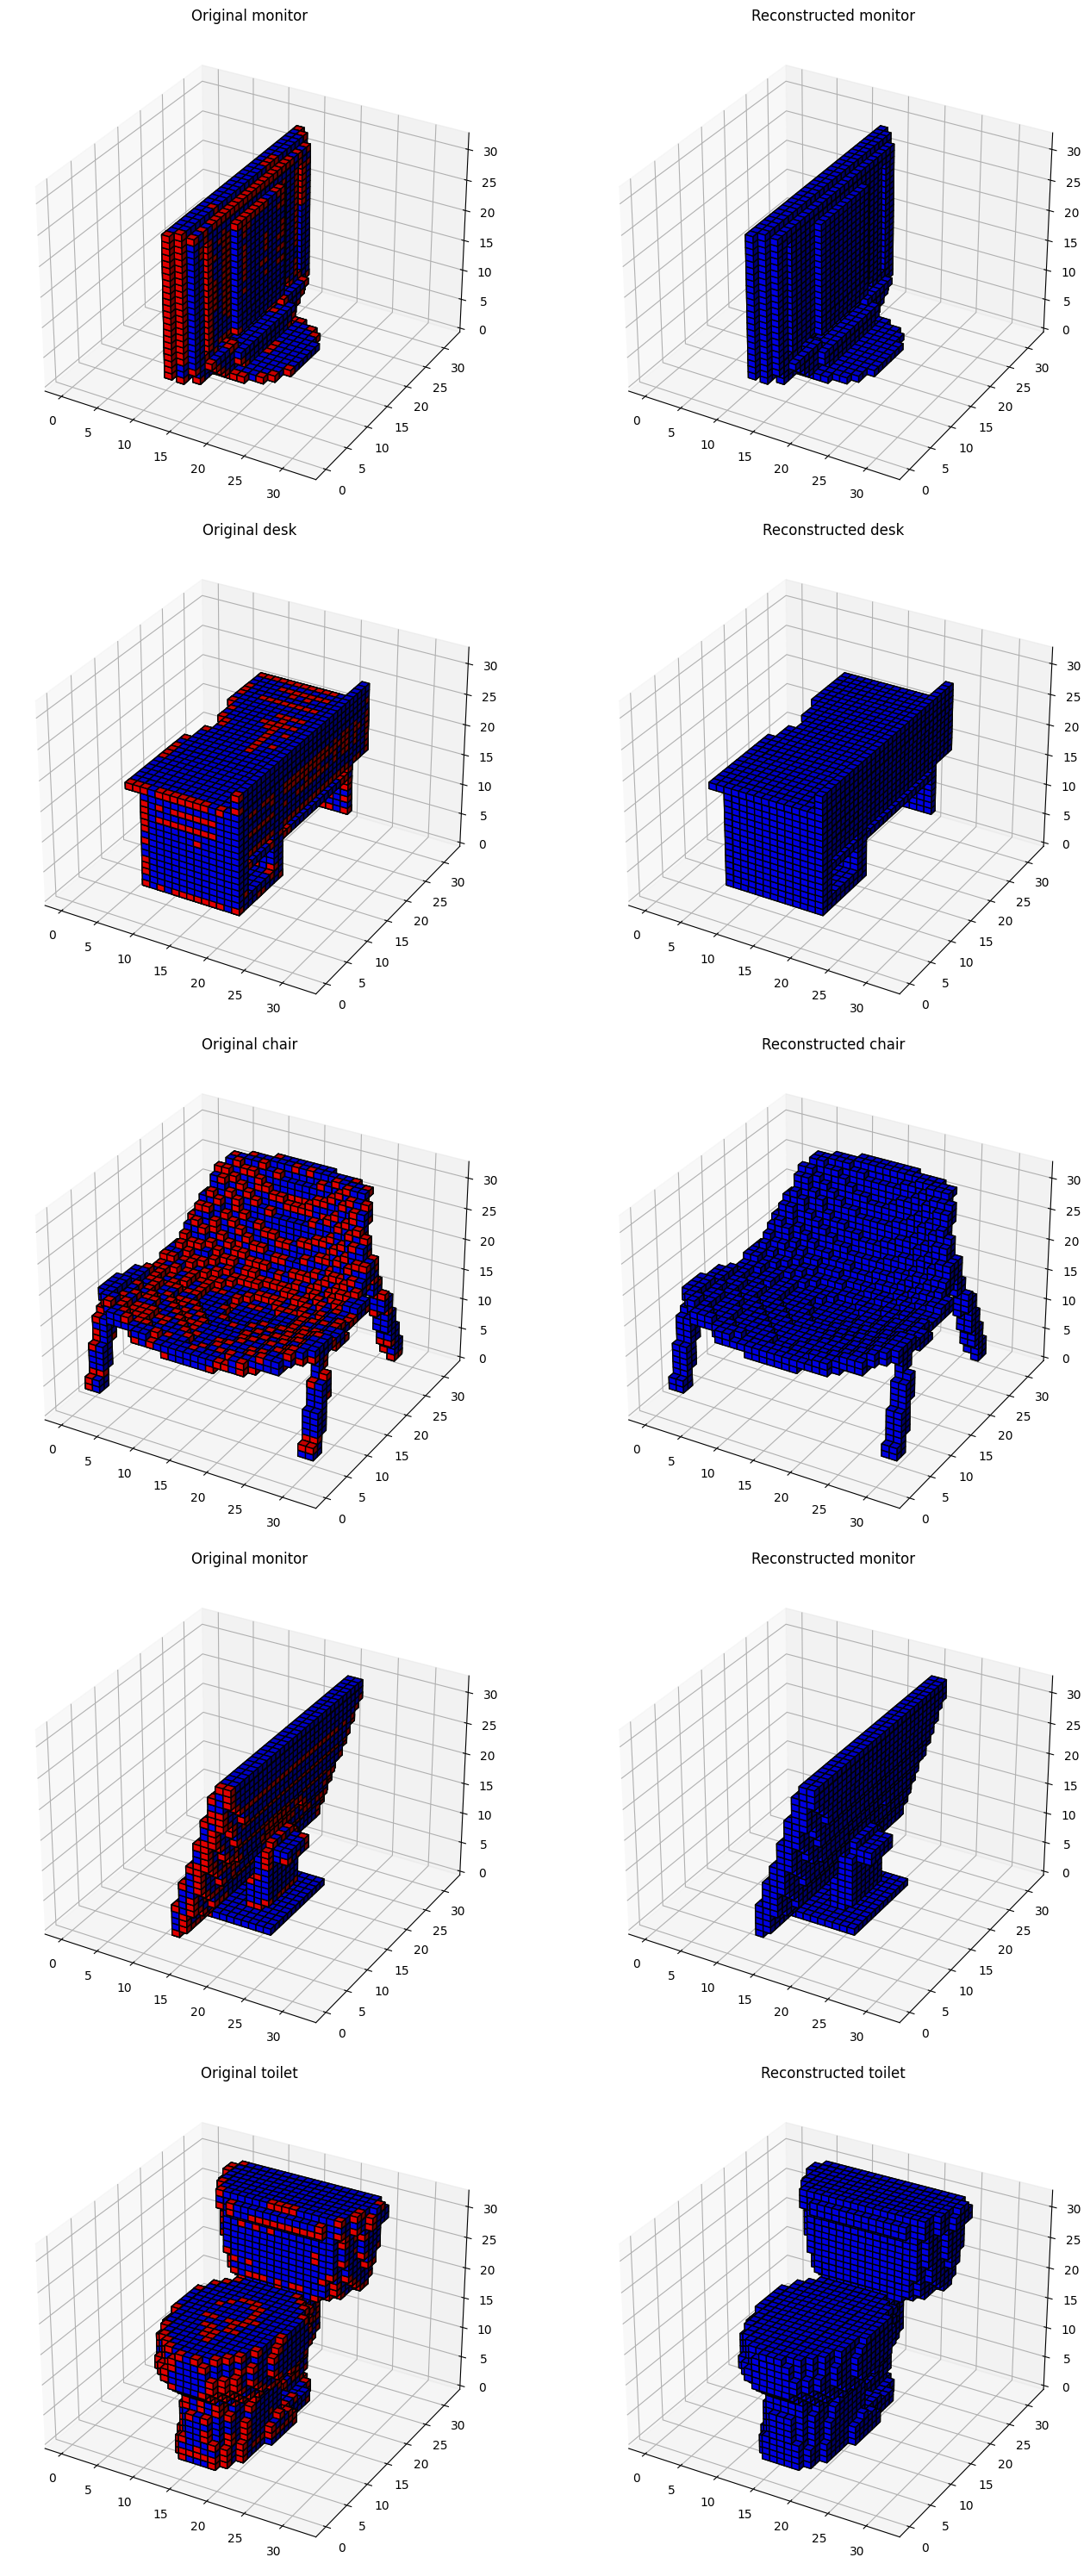

In [ ]:
visualize_objects(original_data, reconstructed_data, labels, important_voxels=important_errors.squeeze())